# Primary model experiments

This notebook intends to test the models specified in the file `preliminary_model.pdf` to estimate prevalence. 

In [1]:
import numpy as np
import pandas as pd
import pystan as ps
from scipy.special import logit, expit

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import pickle
from tqdm.notebook import tqdm

## Notebook settings

In [2]:
sns.set()
plt.rc('mathtext', fontset="cm")
ro = np.random.RandomState(1000)
%matplotlib inline

## Perfect tests

In [3]:
#compiled = False
compiled = True

In [4]:
if compiled: 
    sm = pickle.load(open('pickles/perfect_test.pkl', 'rb'))
else: 
    sm = ps.StanModel(file = 'stan_codes/perfect_test.stan')
    with open('pickles/perfect_test.pkl', 'wb') as f:
        pickle.dump(sm, f)

### Data

First we describe data created artificially. First we create the covariate variables to use in all models. 

In [5]:
n_samples    = 200
n_predictors = 5  
  
x = ro.multivariate_normal(mean = np.zeros(n_predictors), 
                           cov = np.eye(n_predictors),
                           size = n_samples) 

And now we first generate the data considering the model. 

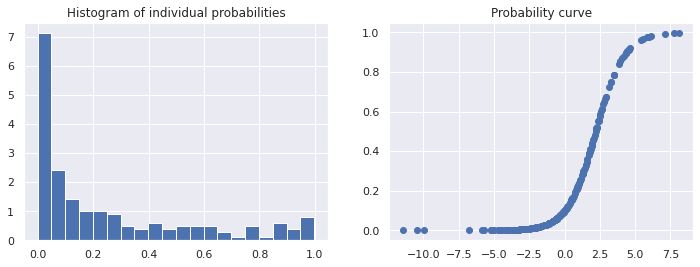

In [6]:
beta = np.array([0.1, 2.5, -1.0, 1.2, 0.3]).reshape(-1,1)
prevalence = 0.1
theta = expit(logit(prevalence) + x@beta)

T = ro.binomial(n = 1, p = theta)

fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].hist(theta, density = True, bins = 20)
ax[1].scatter(x@beta, theta)
ax[0].set_title('Histogram of individual probabilities')
ax[1].set_title('Probability curve')

plt.show()

In [7]:
data = {
    "n_samples"    : n_samples,
    "n_predictors" : n_predictors,
    "T"            : T.flatten(),
    "x"            : x,
}

T.mean()

0.275

Now we describe the necessary pieces to the model. 

In [8]:
Sigma   = np.eye(5)
mu      = np.zeros(5)
alpha_p = 1
beta_p  = 3

data.update({
    "Sigma"        : Sigma,
    "mu"           : mu,
    "alpha_p"      : alpha_p,
    "beta_p"       : beta_p
})

And we apply it to the sampling.

In [9]:
fit_perfect = sm.sampling(data=data, iter=5000)

In [10]:
print(fit_perfect)

Inference for Stan model: anon_model_9b98d602c1db1bbe30bbb5b0245fea83.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

                    mean se_mean     sd   2.5%     25%     50%    75%  97.5%  n_eff   Rhat
effects[1]          0.15  2.2e-3   0.24   -0.3 -6.9e-3    0.15   0.31   0.62  12016    1.0
effects[2]          2.39  4.3e-3   0.36   1.72    2.15    2.38   2.63   3.14   7122    1.0
effects[3]         -0.91  2.4e-3   0.23  -1.38   -1.06   -0.91  -0.74  -0.47   9389    1.0
effects[4]           1.6  3.4e-3   0.29   1.05     1.4    1.59    1.8   2.19   7175    1.0
effects[5]          0.22  2.3e-3   0.24  -0.25    0.06    0.22   0.37   0.68  10780    1.0
prev                0.11  3.6e-4   0.03   0.06    0.09    0.11   0.13   0.17   6766    1.0
effects_prior[1]    0.02    0.01    1.0  -1.97   -0.65    0.02   0.71   1.97   9510    1.0
effects_prior[2]  9.4e-4    0.01   1.01  -1.96   -0.69 -1.6e-3    0.7   1.96   993

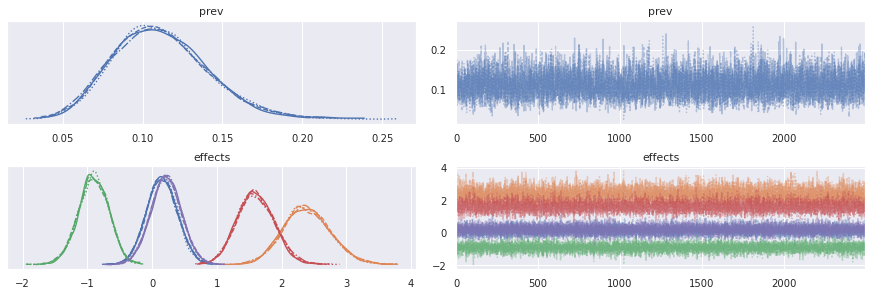

In [11]:
az.plot_trace(fit_perfect, var_names=('prev', 'effects'))
plt.show()

### Practical identifiability

Varying $\beta_1$ value (the intercept) with prevalence fixed. 

In [12]:
x_test = ro.multivariate_normal(mean = np.zeros(1), 
                                cov = np.eye(1),
                                size = 100) 

data_test = {
    "n_samples"    : 100,
    "n_predictors" : 1,
    "x"            : x_test,  
    "Sigma"        : np.eye(1), 
    "mu"           : np.zeros(1),
    "alpha_p"      : 1, 
    "beta_p"       : 3,
    "T"            : 0
}

values = []

for each in tqdm(range(100)): 
    
    beta_test = ro.uniform(-2,2, size=(1,1))
    theta = expit(logit(prevalence) + x_test@beta_test)
    T = ro.binomial(n = 1, p = theta)
    
    data_test.update({
        "T"            : T.flatten(),
    })

    fit_test = sm.sampling(data=data_test) 
    prev_estimated = fit_test.extract()['prev'].mean()
        
    values.append((beta_test[0,0], prev_estimated))
    
values = np.array(values)

  0%|          | 0/100 [00:00<?, ?it/s]

Correlation: -0.04883705594366861


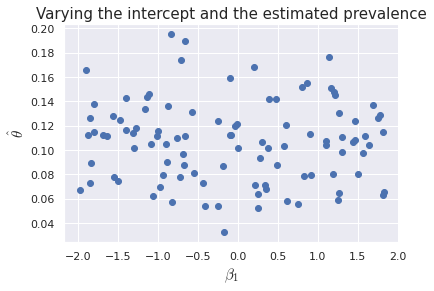

In [13]:
plt.scatter(values[:,0], values[:,1])
print("Correlation: {}".format(np.corrcoef(values[:,0], values[:,1])[0,1]))
plt.xlabel(r'$\beta_1$', fontsize = 15)
plt.ylabel(r'$\hat{\theta}$', fontsize = 15)
plt.title('Varying the intercept and the estimated prevalence', fontsize = 15)
plt.show()

### Priors

Given the priors on the prevalence and on the effects, how it is behaved on the observation-level. 

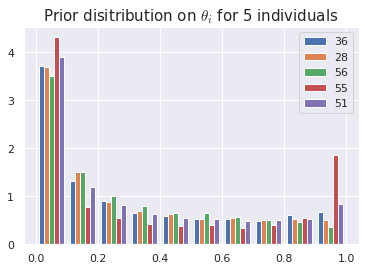

In [14]:
samples = fit_perfect.extract()

ind_prior = expit((logit(samples['prev_prior']) + x@samples['effects_prior'].T))
chosen_individuals = np.random.randint(100,size=5)
plt.hist([ind_prior[i] for i in chosen_individuals], 
         density = True, label = chosen_individuals)
plt.title(r'Prior disitribution on $\theta_i$ for 5 individuals', fontsize = 15)
plt.legend()
plt.show()

## Imperfect tests

Now, we add specificity and sensitivity to the modeling. 

In [15]:
#compiled = False
compiled = True

In [16]:
if compiled: 
    sm = pickle.load(open('pickles/imperfect_test.pkl', 'rb'))
else: 
    sm = ps.StanModel(file = 'stan_codes/imperfect_test.stan')
    with open('pickles/imperfect_test.pkl', 'wb') as f:
        pickle.dump(sm, f)

### Data

First we describe data created artificially. 

In [25]:
spec = 0.85
sens = 0.8

theta = expit(logit(prevalence) + x@beta)
p = sens*theta + (1 - spec)*(1 - theta)

T = ro.binomial(n = 1, p = p)

alpha_s = 4
beta_s  = 1
alpha_e = 4
beta_e  = 1

data = {
    "n_samples"    : n_samples,
    "n_predictors" : n_predictors,
    "T"            : T.flatten(),
    "x"            : x,
    
    "Sigma"        : Sigma,
    "mu"           : mu,
    "alpha_p"      : alpha_p,
    "beta_p"       : beta_p,
    "alpha_s"      : alpha_s,
    "beta_s"       : beta_s,
    "alpha_e"      : alpha_e,
    "beta_e"       : beta_e,

}

T.mean()

0.325

And we apply it

In [28]:
fit_imperfect = sm.sampling(data=data, iter=5000)

In [38]:
#print(fit_imperfect)